<a href="https://colab.research.google.com/github/Sreyosee/Loan_Approval_Predictor/blob/main/Task3_Loan_Approval_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
# task3_loan_approval_prediction.py
import json
import numpy as np
import pandas as pd
import streamlit as st
from joblib import load

st.set_page_config(page_title="Loan Approval Predictor", page_icon="💳", layout="centered")

@st.cache_resource
def load_assets():
    model = load("loan_approval_pipeline.joblib")  # trained in your notebook
    with open("schema.json", "r") as f:
        schema = json.load(f)
    return model, schema

try:
    model, schema = load_assets()
except FileNotFoundError as e:
    st.error(f"Missing file: {e}. Make sure loan_approval_pipeline.joblib and schema.json are in the same folder as this app.")
    st.stop()

num_cols = schema.get("num_cols", [])
cat_cols = schema.get("cat_cols", [])
defaults = schema.get("defaults", {})

st.title("💳 Loan Approval Predictor")
st.caption("Preprocessing + SMOTE are inside the saved sklearn pipeline.")

with st.form("loan_form"):
    st.subheader("Applicant Details")
    colA, colB = st.columns(2)
    values = {}

    # numeric fields
    for i, c in enumerate(num_cols):
        with (colA if i % 2 == 0 else colB):
            values[c] = st.number_input(c, value=float(defaults.get(c, 0.0)))

    # categorical fields
    for i, c in enumerate(cat_cols):
        with (colA if i % 2 == 0 else colB):
            values[c] = st.text_input(c, value=str(defaults.get(c, "")))

    submitted = st.form_submit_button("Predict")

if submitted:
    X_infer = pd.DataFrame([values])
    pred = model.predict(X_infer)[0]
    prob = model.predict_proba(X_infer)[0][1] if hasattr(model, "predict_proba") else None

    st.markdown("---")
    st.subheader("Result")
    label = "✅ Approved" if int(pred) == 1 else "❌ Not Approved"
    st.markdown(f"**Prediction:** {label}")
    if prob is not None:
        st.markdown(f"**Approval probability:** `{prob:.3f}`")


2025-10-06 17:01:54.546 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-06 17:01:54.550 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-06 17:01:54.551 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-06 17:01:54.552 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-06 17:01:54.553 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-06 17:01:54.562 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-06 17:01:54.563 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-06 17:01:54.564 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [26]:
import numpy, pandas as pd, sklearn, imblearn, matplotlib, seaborn
print("numpy:", numpy.__version__)
print("pandas:", pd.__version__)
print("scikit-learn:", sklearn.__version__)
print("imbalanced-learn:", imblearn.__version__)
print("matplotlib:", matplotlib.__version__)
print("seaborn:", seaborn.__version__)


numpy: 1.26.4
pandas: 2.2.2
scikit-learn: 1.6.1
imbalanced-learn: 0.13.0
matplotlib: 3.9.4
seaborn: 0.13.2


In [27]:
# --- 1) Imports & Config ---
import os, json, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline as SkPipeline

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from joblib import dump, load
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
pd.set_option("display.max_columns", 200)

In [40]:
df = pd.read_csv("loan_approval_dataset.csv")
print(df.shape)
df.head()

(4269, 13)


,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [30]:
# If you know your target column, set it here; else we'll guess from common names.
OVERRIDE_TARGET = None  # e.g., "Loan_Status"

candidate_targets = [
    "Loan_Status","loan_status","LoanStatus","Status","approved","Approved","is_approved","target","Outcome"
]
target_col = None

if OVERRIDE_TARGET and OVERRIDE_TARGET in df.columns:
    target_col = OVERRIDE_TARGET
else:
    for c in candidate_targets:
        if c in df.columns:
            target_col = c
            break
    if target_col is None:
        # fallback: assume last column is the target
        target_col = df.columns[-1]

print("Target column:", target_col)

# Build X, y
y_raw = df[target_col]
X = df.drop(columns=[target_col])

# Map common string labels to 0/1 (you can extend mapping if needed)
mapping = {
    "Y":1,"N":0, "Yes":1,"No":0, "Approved":1,"Rejected":0, "A":1,"R":0,
    "True":1,"False":0, "1":1,"0":0
}

if y_raw.dtype == "O":
    y = y_raw.astype(str).map(lambda v: mapping.get(v.strip(), np.nan))
    if y.isna().any():
        # fallback: factorize to integers starting at 0
        y = pd.Series(pd.factorize(y_raw)[0], index=y_raw.index)
else:
    # numeric: if >2 classes, keep as-is; if many values but should be binary, you can threshold later
    y = y_raw.astype(int) if y_raw.nunique() <= 2 else pd.Series(pd.factorize(y_raw)[0], index=y_raw.index)

print("Target distribution:\n", y.value_counts(normalize=True).round(3))


Target column:  loan_status
Target distribution:
  loan_status
1    0.622
0    0.378
Name: proportion, dtype: float64


In [31]:
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
print("Numeric:", num_cols)
print("Categorical:", cat_cols)

numeric_tf = SkPipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_tf = SkPipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_tf, num_cols),
        ("cat", categorical_tf, cat_cols),
    ],
    remainder="drop"
)


Numeric: ['loan_id', ' no_of_dependents', ' income_annum', ' loan_amount', ' loan_term', ' cibil_score', ' residential_assets_value', ' commercial_assets_value', ' luxury_assets_value', ' bank_asset_value']
Categorical: [' education', ' self_employed']


In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

X_train.shape, X_test.shape


((3415, 12), (854, 12))

In [33]:
logreg_pipe = ImbPipeline(steps=[
    ("pre", preprocessor),
    ("smote", SMOTE(random_state=RANDOM_STATE)),
    ("clf", LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))
])

tree_pipe = ImbPipeline(steps=[
    ("pre", preprocessor),
    ("smote", SMOTE(random_state=RANDOM_STATE)),
    ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE))
])


In [34]:
def fit_and_report(name, pipe, X_tr, y_tr, X_te, y_te):
    pipe.fit(X_tr, y_tr)
    y_pred = pipe.predict(X_te)

    print(f"\n=== {name} | Test set report ===")
    print(classification_report(y_te, y_pred, digits=3))

    # Confusion matrix
    cm = confusion_matrix(y_te, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(values_format="d")
    plt.title(f"{name} — Confusion Matrix")
    plt.show()

    # Optional: ROC-AUC (only meaningful for binary + has predict_proba)
    auc = None
    if hasattr(pipe, "predict_proba") and len(np.unique(y_te)) == 2:
        proba = pipe.predict_proba(X_te)[:, 1]
        try:
            auc = roc_auc_score(y_te, proba)
            print(f"ROC-AUC: {auc:.3f}")
        except Exception:
            pass

    f1 = f1_score(y_te, y_pred, average="macro")
    print(f"F1-macro: {f1:.3f}")
    return {"model": pipe, "f1_macro": f1, "roc_auc": auc}



=== Logistic Regression (SMOTE) | Test set report ===
              precision    recall  f1-score   support

           0      0.880     0.932     0.905       323
           1      0.957     0.923     0.940       531

    accuracy                          0.926       854
   macro avg      0.919     0.927     0.922       854
weighted avg      0.928     0.926     0.927       854



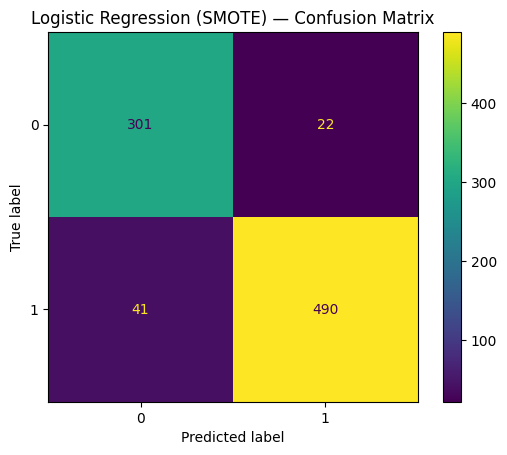

ROC-AUC: 0.973
F1-macro: 0.922

=== Decision Tree (SMOTE) | Test set report ===
              precision    recall  f1-score   support

           0      0.969     0.966     0.967       323
           1      0.979     0.981     0.980       531

    accuracy                          0.975       854
   macro avg      0.974     0.974     0.974       854
weighted avg      0.975     0.975     0.975       854



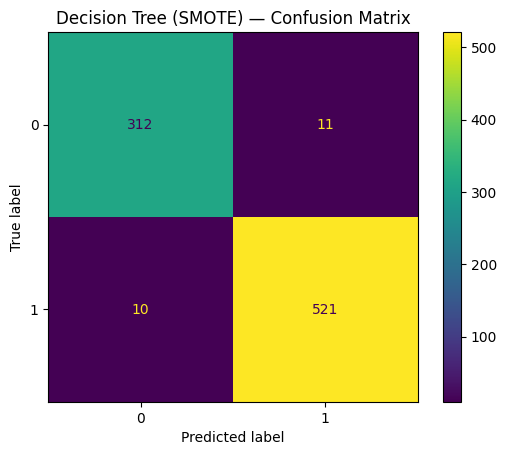

ROC-AUC: 0.974
F1-macro: 0.974


In [35]:
res_log = fit_and_report("Logistic Regression (SMOTE)", logreg_pipe, X_train, y_train, X_test, y_test)
res_tree = fit_and_report("Decision Tree (SMOTE)",      tree_pipe,  X_train, y_train, X_test, y_test)


In [36]:
best = res_log if res_log["f1_macro"] >= res_tree["f1_macro"] else res_tree
best_name = "logreg" if best is res_log else "tree"
print("Selected best model:", best_name, "F1-macro:", best["f1_macro"])

MODEL_PATH = "loan_approval_pipeline.joblib"
dump(best["model"], MODEL_PATH)
print("Saved:", MODEL_PATH)

# Save a tiny schema to help a Streamlit UI later
schema = {
    "num_cols": num_cols,
    "cat_cols": cat_cols,
    "defaults": {
        **{c: float(pd.to_numeric(X[c], errors="coerce").median()) for c in num_cols},
        **{c: (X[c].mode(dropna=True).iloc[0] if not X[c].mode(dropna=True).empty else "") for c in cat_cols}
    }
}
with open("schema.json", "w") as f:
    json.dump(schema, f, indent=2)
print("Saved: schema.json")


Selected best model: tree F1-macro: 0.9738432256229627
Saved: loan_approval_pipeline.joblib
Saved: schema.json


In [37]:
model = load(MODEL_PATH)

example = {}
for c in X.columns:
    if c in num_cols:
        example[c] = float(pd.to_numeric(X[c], errors="coerce").median())
    else:
        m = X[c].mode(dropna=True)
        example[c] = m.iloc[0] if not m.empty else ""

ex_df = pd.DataFrame([example])
pred = model.predict(ex_df)[0]
proba = model.predict_proba(ex_df)[0][1] if hasattr(model, "predict_proba") else None

print("Predicted class:", int(pred))
print("Approval probability:", None if proba is None else round(float(proba), 3))


Predicted class: 1
Approval probability: 1.0
